<a href="https://colab.research.google.com/github/VishakBharadwaj94/amazon_dataset_kaggle/blob/master/amazon_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from fastai.vision import *

In [3]:
! {sys.executable} -m pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.5)


In [0]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

In [6]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [7]:

! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
! unzip -q -n {path}/train_v2.csv.zip -d {path}

 99% 593M/600M [00:10<00:00, 34.0MB/s]
100% 600M/600M [00:10<00:00, 60.4MB/s]
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 58.0MB/s]


In [8]:
! pip install --yes --prefix {sys.prefix} -c haasad eidl7zip


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --yes


In [0]:
!7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

In [10]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

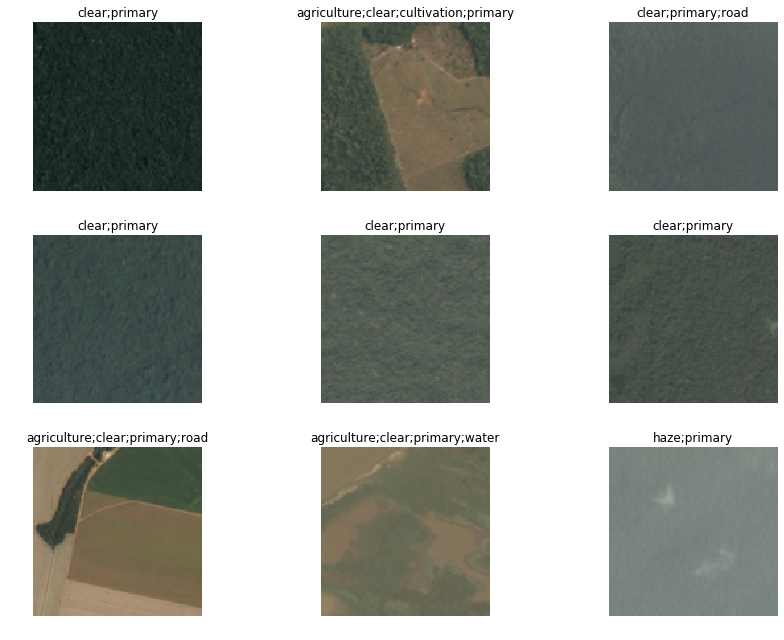

In [13]:
data.show_batch(rows=3, figsize=(12,9))

In [14]:
arch = models.resnet50
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 77157958.20it/s]


In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


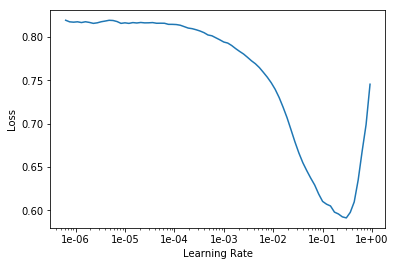

In [16]:
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(6,max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.117988,0.109841,0.945660,0.905172,02:38
1,0.114627,0.105940,0.941998,0.907168,02:38
2,0.107207,0.102499,0.948995,0.912906,02:36
3,0.100034,0.092924,0.957570,0.920554,02:33
4,0.094660,0.085265,0.956320,0.927054,02:35
5,0.088593,0.084191,0.957505,0.927736,02:35


In [0]:
learn.save('stage-1-rn50')

In [0]:
learn.unfreeze()

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


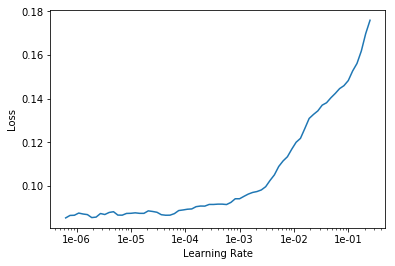

In [21]:
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(5, slice(1e-5, 1e-2/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.094651,0.088126,0.952745,0.924832,02:45
1,0.095925,0.087273,0.958275,0.924911,02:46
2,0.092355,0.085272,0.958740,0.927354,02:45
3,0.086039,0.083551,0.957519,0.926930,02:45
4,0.084117,0.082783,0.957693,0.928266,02:48


In [0]:
learn.save('stage-2-rn50')
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


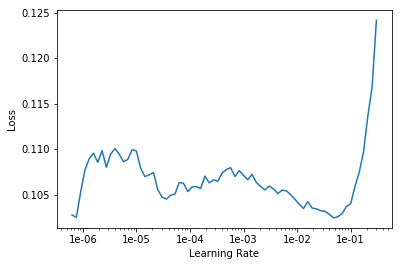

In [24]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.load('stage-2-rn50')

Learner(data=ImageDataBunch;

Train: LabelList (32384 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
haze;primary,agriculture;clear;primary;water,clear;primary,clear;primary,agriculture;clear;habitation;primary;road
Path: /root/.fastai/data/planet;

Valid: LabelList (8095 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
partly_cloudy;primary;road;water,partly_cloudy;primary,cloudy,cloudy,agriculture;blow_down;partly_cloudy;primary
Path: /root/.fastai/data/planet;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Seque

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


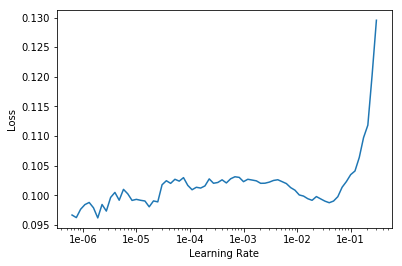

In [29]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [30]:
lr=1e-2/2
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.092145,0.087715,0.954649,0.923432,05:17
1,0.089774,0.085116,0.959248,0.927873,05:20
2,0.090962,0.083548,0.958907,0.928385,05:21
3,0.087453,0.082424,0.957250,0.928320,05:17
4,0.086177,0.081989,0.957693,0.928191,05:18


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


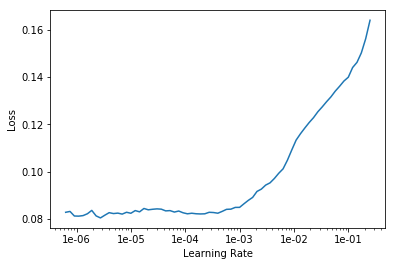

In [31]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.save('stage-2-rn50')

In [33]:
learn.fit_one_cycle(4,max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.085201,0.082316,0.958130,0.928661,07:02
1,0.084011,0.081969,0.958086,0.929144,07:01
2,0.082507,0.081060,0.958675,0.930072,07:01
3,0.081490,0.080789,0.958405,0.930314,07:01


In [0]:
learn.save('stage-3-rn50')

In [36]:
learn.load('stage-3-rn50')
learn.fit_one_cycle(2,max_lr=slice(1e-6,1e-5),wd=0.1)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.082059,0.080670,0.958791,0.930451,07:01
1,0.083788,0.081004,0.960251,0.930343,06:58


In [0]:
learn.save('stage-4-rn50')

In [38]:
learn.fit_one_cycle(2,max_lr=slice(1e-6,1e-5),wd=0.3)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.081446,0.080591,0.959205,0.930470,06:58
1,0.081614,0.080592,0.959241,0.930394,06:57


In [0]:
learn.save('stage-5-rn50')